<a href="https://colab.research.google.com/github/Muhammadsulton1/ML/blob/main/%D0%93%D1%80%D1%8F%D0%B7%D0%BD%D1%8B%D0%B5_%D1%82%D0%B0%D1%80%D0%B5%D0%BB%D0%BA%D0%B8_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import os
import torch

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/platesv2.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('plates')

In [ ]:
with zipfile.ZipFile('/content/plates/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('plates/plates')

In [ ]:
print('After zip extraction:')
print(os.listdir("plates/plates/plates"))

After zip extraction:
['test', '.DS_Store', 'train']


In [ ]:
data_root = 'plates/plates/plates'
print(os.listdir(data_root))

['test', '.DS_Store', 'train']


In [ ]:
import shutil 
from tqdm import tqdm

In [ ]:
train_dir = 'train'#создается папка для тренировки и каждая  фотка кладется в папку для волидации
val_dir = 'val'#папка для валидациии
class_names = ['cleaned', 'dirty']

In [ ]:
#вот эта ячейка берет каждую 6 фотку и кладет ее в папку для валидации
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 2250.97it/s]


In [ ]:
!ls train

cleaned  dirty


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

In [ ]:
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),#выразание участков изображения(аугументация) и отресайзит до размера 224
    transforms.RandomHorizontalFlip(),#отзеркалим относительно горизонтали
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(224),
    transforms.RandomRotation(5),
    transforms.ToTensor(),#превращаем в тензор все
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#нормализация картинов по этим константам есть на сайте пайторча
])

In [ ]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),#ужимаем изображение до размера 224 на 224
    transforms.ToTensor(),#превращаем изображение в тензор
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#нормализация картинов по этим константам есть на сайте пайторча
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)#ImageFolder передает изображение в виде тензора,если он с 1 агрументом то не в виде тензора
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader( #на вход принимает imageFolder перемещивает датасет
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#проверяем делиться ли на цело количество изображений на батч, то последний батч будет не полным и он не участвует в обучении нейронки
len(train_dataloader), len(train_dataset)

(4, 32)

Чтобы посмотреть на это высчитываем все обратно т.е. нормировка обраьная

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


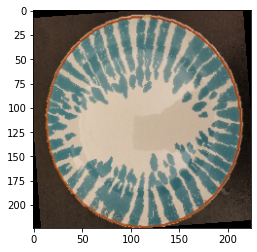

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);#permute нужен потому что тензор меняет размерность а пермют возвражает его в начальный вид

Посмотрим изображения

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


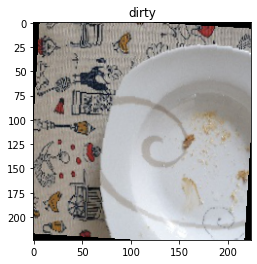

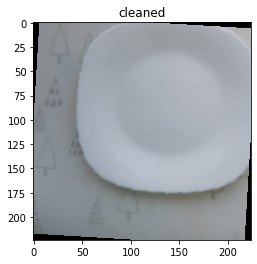

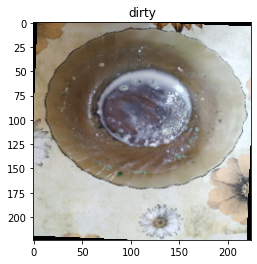

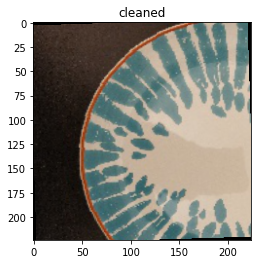

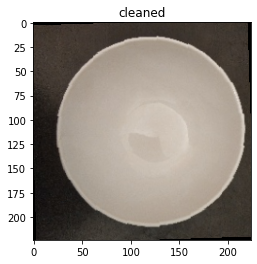

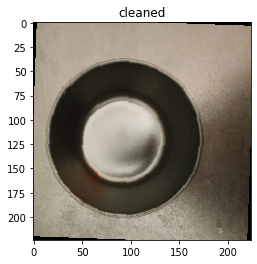

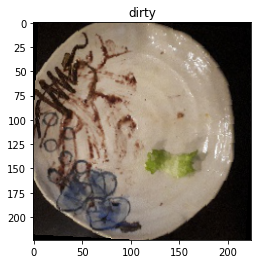

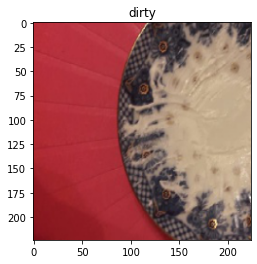

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
#функция для обучения нейросети имеет две фазы такие как валидация и тренировка
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):#иттератор по эпохам
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':#если фаза равна тренировки то она делает градиентные шаги
                dataloader = train_dataloader #дает нам батчи
                scheduler.step() #делает градиентный шаг с который уменьшается через каждые 7 эпох
                model.train()  # Set model to training mode
            else:#иначе переходит в эволюцию и считаем качество валидации не переобучилась ли модель
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):#иттерируемся и получаем один батч и один тензор и переводим их на гпу
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()#обнуляем градиент чтобы они не накапливались

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):#если фаза равно трейн то мы активируем те градиенты которые не замороженны 
                    preds = model(inputs)#считаем предикшины
                    loss_value = loss(preds, labels)#посчитали лоссы 
                    preds_class = preds.argmax(dim=1)#что за класс предсказала наша сетка

                    # backward + optimize only if in training phase
                    if phase == 'train':#если фаза трейн 
                        loss_value.backward()#считаем производную
                        optimizer.step()#делаем градиентный шаг

                # statistics
                running_loss += loss_value.item()#считаются лоссы
                running_acc += (preds_class == labels.data).float().mean()#считаются точности

            epoch_loss = running_loss / len(dataloader) #делим на кол-во батчей
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [ ]:
"""
class Plates(torch.nn.Module):
  def __init__(self):
    super(Plates,self).__init__()

    self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=2),
                                     torch.nn.MaxPool2d(kernel_size=2,stride=2),
                                     torch.nn.ReLU(),
                                     torch.nn.BatchNorm2d(16)
                                     )
    self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=16,out_channels=64,kernel_size=3,stride=1,padding=2),
                                     torch.nn.BatchNorm2d(64),
                                     torch.nn.MaxPool2d(kernel_size=2,stride=2),
                                     torch.nn.ReLU()
                                     )
    self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                                     torch.nn.BatchNorm2d(128),
                                     torch.nn.MaxPool2d(kernel_size=2,stride=2),
                                     torch.nn.ReLU()
                                    )
    self.conv4 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                                     torch.nn.BatchNorm2d(256),
                                     torch.nn.MaxPool2d(kernel_size=2,stride=2),
                                     torch.nn.ReLU()
                                     )
    self.conv5 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=0),
                                     torch.nn.BatchNorm2d(512),
                                     torch.nn.MaxPool2d(kernel_size=2,stride=2),
                                     torch.nn.ReLU()
                                     )
    
    self.out = torch.nn.Sequential(torch.nn.Linear(224*3*3,1024),
                                   torch.nn.ReLU(),
                                   torch.nn.Dropout(0.3),
                                   torch.nn.Linear(1024,1024),
                                   torch.nn.ReLU(),
                                   torch.nn.Dropout(0.3),
                                   torch.nn.Linear(1024,2)
                                   )
    
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
      
    print(x.shape)

    x = x.view(x.size(0),-1)
    x = self.out(x)
    return x

plates = Plates()
"""

'\nclass Plates(torch.nn.Module):\n  def __init__(self):\n    super(Plates,self).__init__()\n\n    self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=2),\n                                     torch.nn.MaxPool2d(kernel_size=2,stride=2),\n                                     torch.nn.ReLU(),\n                                     torch.nn.BatchNorm2d(16)\n                                     )\n    self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=16,out_channels=64,kernel_size=3,stride=1,padding=2),\n                                     torch.nn.BatchNorm2d(64),\n                                     torch.nn.MaxPool2d(kernel_size=2,stride=2),\n                                     torch.nn.ReLU()\n                                     )\n    self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),\n                                     torch.nn.BatchNorm2d(128),\n

Строим модель RESENET50 (50 слоев)

In [ ]:
model = models.resnet101(pretrained=True)

#данный цикл обучает только последний слой нейросети где она отвечает за классификацию
for param in model.parameters():
    param.requires_grad = False

#model.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features,model.fc.in_features),
                               #torch.nn.ReLU(),
                               #torch.nn.Dropout(0.3),
                               #torch.nn.Linear(model.fc.in_features,2))

model.fc = torch.nn.Linear(model.fc.in_features, 2)#полносвязный линейный слой, поскольку RESENET ОН ДЛЯ 1000 КЛАССОВ А У НАС ИХ 2 В ПРИМЕРЕ
#model.fc.in_features - сколько фичей приходит на вход (нейронов) на выход нам нужно 2 нейрона
#переводи нашу архитектуру на ГПУ для быстроты вычислений
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

#планировщик для уменьшения градиентных шагов уменьшает каждые 7 эпох чтобы градиент не попопал локальный минимум
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=25); #модель тренировочная с 100 эпохами

Epoch 0/24:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slown

train Loss: 0.6834 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

val Loss: 0.5837 Acc: 0.6250
Epoch 1/24:



100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

train Loss: 0.6767 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

val Loss: 0.5762 Acc: 0.8750
Epoch 2/24:



100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

train Loss: 0.5745 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

val Loss: 0.5972 Acc: 0.6250
Epoch 3/24:



100%|██████████| 4/4 [00:01<00:00,  3.87it/s]

train Loss: 0.5853 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

val Loss: 0.6514 Acc: 0.5000
Epoch 4/24:



100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

train Loss: 0.4326 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

val Loss: 0.5959 Acc: 0.7500
Epoch 5/24:



100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

train Loss: 0.5066 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

val Loss: 0.6044 Acc: 0.7500
Epoch 6/24:



100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

train Loss: 0.4507 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

val Loss: 0.5780 Acc: 0.8750
Epoch 7/24:



100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

train Loss: 0.3254 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

val Loss: 0.5842 Acc: 0.7500
Epoch 8/24:



100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

train Loss: 0.4130 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

val Loss: 0.5726 Acc: 0.7500
Epoch 9/24:



100%|██████████| 4/4 [00:01<00:00,  3.80it/s]

train Loss: 0.4503 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

val Loss: 0.5871 Acc: 0.7500
Epoch 10/24:



100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

train Loss: 0.3883 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

val Loss: 0.5789 Acc: 0.6250
Epoch 11/24:



100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

train Loss: 0.3641 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

val Loss: 0.5877 Acc: 0.6250
Epoch 12/24:



100%|██████████| 4/4 [00:01<00:00,  3.70it/s]

train Loss: 0.4007 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

val Loss: 0.5965 Acc: 0.6250
Epoch 13/24:



100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

train Loss: 0.4264 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

val Loss: 0.5961 Acc: 0.7500
Epoch 14/24:



100%|██████████| 4/4 [00:01<00:00,  3.60it/s]

train Loss: 0.3798 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

val Loss: 0.5925 Acc: 0.7500
Epoch 15/24:



100%|██████████| 4/4 [00:01<00:00,  3.63it/s]

train Loss: 0.4216 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

val Loss: 0.5965 Acc: 0.6250
Epoch 16/24:



100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

train Loss: 0.4378 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

val Loss: 0.5844 Acc: 0.6250
Epoch 17/24:



100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

train Loss: 0.4100 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

val Loss: 0.5898 Acc: 0.6250
Epoch 18/24:



100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

train Loss: 0.3921 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

val Loss: 0.5986 Acc: 0.6250
Epoch 19/24:



100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

train Loss: 0.3796 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

val Loss: 0.6032 Acc: 0.6250
Epoch 20/24:



100%|██████████| 4/4 [00:01<00:00,  3.66it/s]

train Loss: 0.4243 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 0.5979 Acc: 0.6250
Epoch 21/24:



100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

train Loss: 0.3828 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

val Loss: 0.5900 Acc: 0.6250
Epoch 22/24:



100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

train Loss: 0.3961 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 0.5991 Acc: 0.6250
Epoch 23/24:



100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

train Loss: 0.3633 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

val Loss: 0.5990 Acc: 0.6250
Epoch 24/24:



100%|██████████| 4/4 [00:01<00:00,  3.64it/s]

train Loss: 0.4504 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

val Loss: 0.5946 Acc: 0.7500


In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=100)

Epoch 0/99:


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

train Loss: 0.6697 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

val Loss: 0.6587 Acc: 0.5000
Epoch 1/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6784 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

val Loss: 0.6618 Acc: 0.3750
Epoch 2/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6912 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.6579 Acc: 0.5000
Epoch 3/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6759 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.6646 Acc: 0.3750
Epoch 4/99:



100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

train Loss: 0.6637 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6624 Acc: 0.5000
Epoch 5/99:



100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

train Loss: 0.6934 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

val Loss: 0.6632 Acc: 0.3750
Epoch 6/99:



100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

train Loss: 0.6961 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 0.6665 Acc: 0.3750
Epoch 7/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6849 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

val Loss: 0.6623 Acc: 0.5000
Epoch 8/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6721 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.6685 Acc: 0.3750
Epoch 9/99:



100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

train Loss: 0.6759 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.6645 Acc: 0.3750
Epoch 10/99:



100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

train Loss: 0.6818 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.6658 Acc: 0.3750
Epoch 11/99:



100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

train Loss: 0.6685 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

val Loss: 0.6636 Acc: 0.3750
Epoch 12/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6885 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.6638 Acc: 0.3750
Epoch 13/99:



100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

train Loss: 0.6902 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.6623 Acc: 0.3750
Epoch 14/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6818 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.6680 Acc: 0.3750
Epoch 15/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6815 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

val Loss: 0.6669 Acc: 0.3750
Epoch 16/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6903 Acc: 0.4375



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6652 Acc: 0.3750
Epoch 17/99:



100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

train Loss: 0.6774 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.6685 Acc: 0.3750
Epoch 18/99:



100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

train Loss: 0.6677 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

val Loss: 0.6723 Acc: 0.3750
Epoch 19/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6906 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.6754 Acc: 0.3750
Epoch 20/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6998 Acc: 0.4062



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6678 Acc: 0.3750
Epoch 21/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6798 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

val Loss: 0.6611 Acc: 0.3750
Epoch 22/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6954 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6617 Acc: 0.3750
Epoch 23/99:



100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

train Loss: 0.6914 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.6567 Acc: 0.5000
Epoch 24/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6598 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6571 Acc: 0.5000
Epoch 25/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6620 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

val Loss: 0.6572 Acc: 0.3750
Epoch 26/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6738 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.6530 Acc: 0.3750
Epoch 27/99:



100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

train Loss: 0.6993 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

val Loss: 0.6561 Acc: 0.3750
Epoch 28/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6868 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

val Loss: 0.6583 Acc: 0.3750
Epoch 29/99:



100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

train Loss: 0.6859 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

val Loss: 0.6567 Acc: 0.3750
Epoch 30/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6940 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

val Loss: 0.6610 Acc: 0.3750
Epoch 31/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6732 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.6643 Acc: 0.3750
Epoch 32/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6900 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.6707 Acc: 0.3750
Epoch 33/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6858 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.6726 Acc: 0.3750
Epoch 34/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6902 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.6698 Acc: 0.3750
Epoch 35/99:



100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

train Loss: 0.7082 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

val Loss: 0.6645 Acc: 0.3750
Epoch 36/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6723 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.6675 Acc: 0.3750
Epoch 37/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6803 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.6687 Acc: 0.3750
Epoch 38/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6958 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.6635 Acc: 0.3750
Epoch 39/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6757 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6698 Acc: 0.3750
Epoch 40/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6895 Acc: 0.4375



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.6627 Acc: 0.3750
Epoch 41/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6859 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6626 Acc: 0.3750
Epoch 42/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6615 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.6582 Acc: 0.3750
Epoch 43/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6733 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.6552 Acc: 0.5000
Epoch 44/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6812 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.6584 Acc: 0.3750
Epoch 45/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6767 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6622 Acc: 0.3750
Epoch 46/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6781 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6614 Acc: 0.3750
Epoch 47/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6895 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6614 Acc: 0.3750
Epoch 48/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6936 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6619 Acc: 0.3750
Epoch 49/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6639 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.6660 Acc: 0.3750
Epoch 50/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.7291 Acc: 0.4375



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.6678 Acc: 0.3750
Epoch 51/99:



100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

train Loss: 0.6625 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.6760 Acc: 0.3750
Epoch 52/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.7031 Acc: 0.4375



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.6675 Acc: 0.3750
Epoch 53/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6608 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.6680 Acc: 0.3750
Epoch 54/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6918 Acc: 0.4375



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

val Loss: 0.6697 Acc: 0.3750
Epoch 55/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.7043 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.6604 Acc: 0.3750
Epoch 56/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6769 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.6564 Acc: 0.5000
Epoch 57/99:



100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

train Loss: 0.6896 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.6609 Acc: 0.3750
Epoch 58/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6769 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6597 Acc: 0.3750
Epoch 59/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.7141 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.6546 Acc: 0.3750
Epoch 60/99:



100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

train Loss: 0.6743 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.6557 Acc: 0.3750
Epoch 61/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.7091 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

val Loss: 0.6602 Acc: 0.3750
Epoch 62/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.7068 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6647 Acc: 0.3750
Epoch 63/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.6986 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6646 Acc: 0.3750
Epoch 64/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.7068 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.6643 Acc: 0.3750
Epoch 65/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6898 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.6634 Acc: 0.3750
Epoch 66/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6727 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

val Loss: 0.6657 Acc: 0.3750
Epoch 67/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6591 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.6687 Acc: 0.3750
Epoch 68/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6867 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6718 Acc: 0.3750
Epoch 69/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.7033 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.6693 Acc: 0.3750
Epoch 70/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6902 Acc: 0.4375



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.6601 Acc: 0.3750
Epoch 71/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6683 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6661 Acc: 0.3750
Epoch 72/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6803 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6685 Acc: 0.3750
Epoch 73/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6921 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.6631 Acc: 0.3750
Epoch 74/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6846 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6693 Acc: 0.3750
Epoch 75/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6911 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

val Loss: 0.6675 Acc: 0.3750
Epoch 76/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.7101 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6736 Acc: 0.3750
Epoch 77/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6811 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

val Loss: 0.6678 Acc: 0.3750
Epoch 78/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6831 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.6675 Acc: 0.3750
Epoch 79/99:



100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

train Loss: 0.6823 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.6591 Acc: 0.5000
Epoch 80/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.7019 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.6641 Acc: 0.3750
Epoch 81/99:



100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

train Loss: 0.6781 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.6603 Acc: 0.3750
Epoch 82/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6923 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val Loss: 0.6631 Acc: 0.3750
Epoch 83/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.7009 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6629 Acc: 0.3750
Epoch 84/99:



100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

train Loss: 0.7192 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

val Loss: 0.6628 Acc: 0.3750
Epoch 85/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6702 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6623 Acc: 0.3750
Epoch 86/99:



100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

train Loss: 0.6993 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.6614 Acc: 0.3750
Epoch 87/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.7036 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.6618 Acc: 0.3750
Epoch 88/99:



100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

train Loss: 0.6757 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.6622 Acc: 0.5000
Epoch 89/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6984 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.6581 Acc: 0.5000
Epoch 90/99:



100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

train Loss: 0.6855 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

val Loss: 0.6602 Acc: 0.3750
Epoch 91/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6738 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.6591 Acc: 0.3750
Epoch 92/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.6885 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

val Loss: 0.6617 Acc: 0.3750
Epoch 93/99:



100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

train Loss: 0.7005 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.6677 Acc: 0.3750
Epoch 94/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6907 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

val Loss: 0.6621 Acc: 0.5000
Epoch 95/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.6858 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

val Loss: 0.6662 Acc: 0.3750
Epoch 96/99:



100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

train Loss: 0.6810 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.6660 Acc: 0.3750
Epoch 97/99:



100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

train Loss: 0.6903 Acc: 0.4062



100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

val Loss: 0.6718 Acc: 0.3750
Epoch 98/99:



100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

train Loss: 0.6800 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

val Loss: 0.6697 Acc: 0.3750
Epoch 99/99:



100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

train Loss: 0.6472 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

val Loss: 0.6680 Acc: 0.3750


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [ ]:
#класс который отдает путь к изображению
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/content/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /content/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
model.eval()

test_predictions = []#классы предсказанных изображений 
test_img_paths = []#пути к изображению
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)#переводим на гпу
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)#считаем предикшины
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())#можем привритить к вероятности благодаря софтмакс
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)#соединяем предсказанные для тестовой выборки

100%|██████████| 93/93 [00:14<00:00,  6.41it/s]


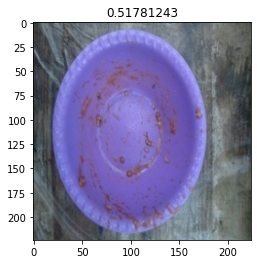

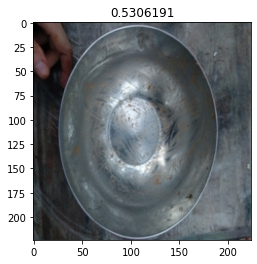

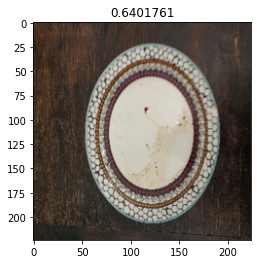

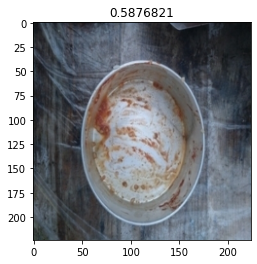

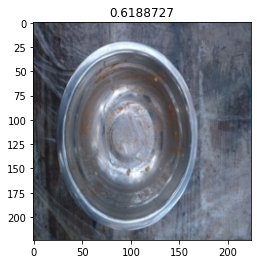

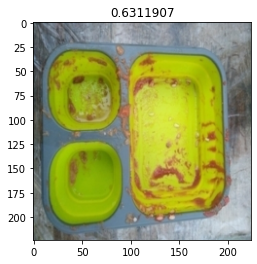

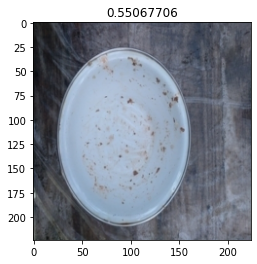

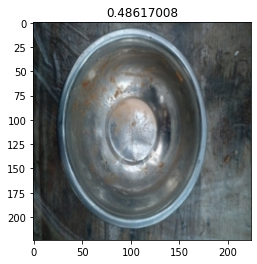

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/test/unknown', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
#submission_df.set_index('id', inplace=True)
submission_df.head(6)

,id,label
0,/0000,dirty
1,/0001,dirty
2,/0002,dirty
3,/0003,dirty
4,/0004,dirty
5,/0005,dirty


In [ ]:
submission_df['id'] = submission_df['id'].str.replace('/','')

In [ ]:
submission_df.head()
submission_df.set_index('id', inplace=True)

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>